<a href="https://colab.research.google.com/github/flupppi/SeniorProject/blob/main/classify_plants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x

# Load the TensorBoard notebook extension.
%load_ext tensorboard

import tensorflow as tf
from tensorflow.keras.models import load_model

print("Tensorflow version " + tf.__version__)

import sys, os, glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.7.0
Found GPU at: /device:GPU:0


In [ ]:
def plot_history(history, fig_name):
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']

	loss = history.history['loss']
	val_loss = history.history['val_loss']

	plt.figure(figsize=(8, 8))
	plt.subplot(2, 1, 1)
	plt.plot(acc, label='Training Accuracy')
	plt.plot(val_acc, label='Validation Accuracy')
	plt.legend(loc='lower right')
	plt.ylabel('Accuracy')
	plt.ylim([0,1])
	plt.title('Training and Validation Accuracy')

	plt.subplot(2, 1, 2)
	plt.plot(loss, label='Training Loss')
	plt.plot(val_loss, label='Validation Loss')
	plt.legend(loc='upper right')
	plt.ylabel('Cross Entropy')
	plt.ylim([0, max(max(loss), max(val_loss))])
	plt.title('Training and Validation Loss')
	plt.xlabel('epoch')
	plt.savefig(fig_name)
 
def save_report(cr, cm, normalized_cm, label_keys):
  filename = os.path.join(output_dir, 'training_report.txt')
  figname = os.path.join(output_dir, 'confusion_matrix.jpg')

  max_len = len(max(label_keys, key=len))
  np.savetxt(filename, cm, fmt='%d')
  with open(filename, 'r') as f:
    matrix = f.readlines()
  with open(filename, 'w') as f:
    f.write(cr)
    f.write('\n\nConfusion Matrix\n-----------------\n')
    for label, row in zip(label_keys, matrix):
      f.write('{}\t{}\n'.format(label.rjust(max_len), row))
    
  sns.heatmap(
      normalized_cm, 
      annot=True)
  plt.title('Normalized Confusion matrix')
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.savefig(figname)

def get_train_val_test_generators(train_dataset_dir, val_dataset_dir, test_dataset_dir):
  seed = 40

  if augment:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        brightness_range=(0.8, 1.2),
        zoom_range=(0.6, 1.5),
        channel_shift_range=50,
        horizontal_flip=True,
        fill_mode="reflect")
  else:
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

  test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

  print("Train generator")
  train_generator = train_datagen.flow_from_directory(
      train_dataset_dir,
      seed=seed,
      target_size=(IMAGE_SIZE, IMAGE_SIZE),
      batch_size=BATCH_SIZE)

  print("Validation generator")
  val_generator = test_datagen.flow_from_directory(
      val_dataset_dir,
      seed=seed,
      target_size=(IMAGE_SIZE, IMAGE_SIZE),
      batch_size=BATCH_SIZE)

  print("Test generator")
  test_generator = test_datagen.flow_from_directory(
      test_dataset_dir,
      shuffle=False,
      seed=seed,
      target_size=(IMAGE_SIZE, IMAGE_SIZE),
      batch_size=BATCH_SIZE)
  
  return train_generator, val_generator, test_generator

In [ ]:
## ------ TRAINING SETTINGS ----- ##

IMAGE_SIZE = 224
BATCH_SIZE = 32
augment = False

EPOCH_FIRST_PHASE = 100
EPOCH_SECOND_PHASE = 50

# Optimizer settings
LR_FIRST_PHASE = 1e-3
LR_SECOND_PHASE = LR_FIRST_PHASE * 1e-2
OPTIMIZER = "adam"  # optimizer options: ["adam", "sgd"]
SGD_MOMENTUM = 0.9  # Used if OPTIMIZER == "sgd"

if OPTIMIZER == "adam":
  optimizer_first_phase = tf.keras.optimizers.Adam(learning_rate=LR_FIRST_PHASE, name='adam_phase1')
  optimizer_second_phase = tf.keras.optimizers.Adam(learning_rate=LR_SECOND_PHASE, name='adam_phase2')
elif OPTIMIZER == "sgd":
  optimizer_first_phase = tf.keras.optimizers.SGD(learning_rate=LR_FIRST_PHASE, momentum=SGD_MOMENTUM, name='sgd_phase1')
  optimizer_second_phase = tf.keras.optimizers.SGD(learning_rate=LR_SECOND_PHASE, momentum=SGD_MOMENTUM, name='sgd_phase2')

## ------------------------------- ##
## ------ DIRECTORY SETTINGS ----- ##

os.chdir('/content/drive/Shareddrives/California Native Plants - Felix Work')

# Dataset directory
dataset_root_dir = 'datasets'
dataset = 'cnp10_splitted'
dataset_dir = os.path.join(dataset_root_dir, dataset)

# Train, Validation and Test Split
train_dataset_dir = os.path.join(dataset_dir, "train")
val_dataset_dir = os.path.join(dataset_dir, "val")
test_dataset_dir = os.path.join(dataset_dir, "test")

# Create output directory
training_name = "{}_{}_lr{}_b{}_e_{}_{}".format('augmented' if augment else 'not_augmented', OPTIMIZER, LR_FIRST_PHASE, BATCH_SIZE, EPOCH_FIRST_PHASE, EPOCH_SECOND_PHASE)
output_dir = os.path.join('training', dataset, training_name)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Working dir: {}".format(os.getcwd()))
print("Train dataset dir: {}".format(train_dataset_dir))
print("Validation dataset dir: {}".format(val_dataset_dir))
print("Test dataset dir: {}".format(test_dataset_dir))
print("Output dir: {}".format(output_dir))
print("Dataset dir folders: {}".format(os.listdir(dataset_dir)))

Working dir: /content/drive/Shareddrives/California Native Plants - Felix Work
Train dataset dir: datasets/cnp10_splitted/train
Validation dataset dir: datasets/cnp10_splitted/val
Test dataset dir: datasets/cnp10_splitted/test
Output dir: training/cnp10_splitted/not_augmented_adam_lr0.001_b32_e_100_50
Dataset dir folders: ['test', 'train', 'val']


In [ ]:
train_generator, val_generator, test_generator = get_train_val_test_generators(train_dataset_dir, val_dataset_dir, test_dataset_dir)

for image_batch, label_batch in train_generator:
  break
print('\nImage batch shape: ', image_batch.shape)
print('Labels batch shape: ', label_batch.shape)

Train generator
Found 5817 images belonging to 10 classes.
Validation generator
Found 1456 images belonging to 10 classes.
Test generator
Found 1559 images belonging to 10 classes.

Image batch shape:  (32, 224, 224, 3)
Labels batch shape:  (32, 10)


In [ ]:
print(train_generator.class_indices)

label_keys = train_generator.class_indices.keys()
num_labels = len(label_keys)
labels = '\n'.join(sorted(label_keys))

with open(os.path.join(output_dir, 'labels.txt'), 'w') as f:
  f.write(labels)

{'Aquilegia formosa': 0, 'Berberis aquifolium': 1, 'Eriogonum arborescens': 2, 'Gambelia speciosa': 3, 'Heteromeles arbutifolia': 4, 'Penstemon spectabilis': 5, 'Rhus integrifolia': 6, 'Ribes aureum': 7, 'Salvia apiana': 8, 'Salvia spathacea': 9}


In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

# First Phase Training

In [ ]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(num_labels, activation='softmax')
])

model.compile(optimizer=optimizer_first_phase, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          368672    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 2,626,986
Trainable params: 369,002
Non-tr

Resuming using saved model training/cnp10_splitted/not_augmented_adam_lr0.001_b32_e_100_50/model.1.16-0.29.h5.


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 17/100
182/182 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9746 
Epoch 00017: val_loss improved from inf to 0.34108, saving model to training/cnp10_splitted/not_augmented_adam_lr0.001_b32_e_100_50/model.1.17-0.34.h5
182/182 [==============================] - 2460s 13s/step - loss: 0.0868 - accuracy: 0.9746 - val_loss: 0.3411 - val_accuracy: 0.9279
Epoch 18/100
182/182 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9768
Epoch 00018: val_loss improved from 0.34108 to 0.32800, saving model to training/cnp10_splitted/not_augmented_adam_lr0.001_b32_e_100_50/model.1.18-0.33.h5
182/182 [==============================] - 164s 899ms/step - loss: 0.0795 - accuracy: 0.9768 - val_loss: 0.3280 - val_accuracy: 0.9368
Epoch 19/100
182/182 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9704
Epoch 00019: val_loss did not improve from 0.32800
182/182 [==============================] - 164s 899ms/step - loss: 0.0931 - acc

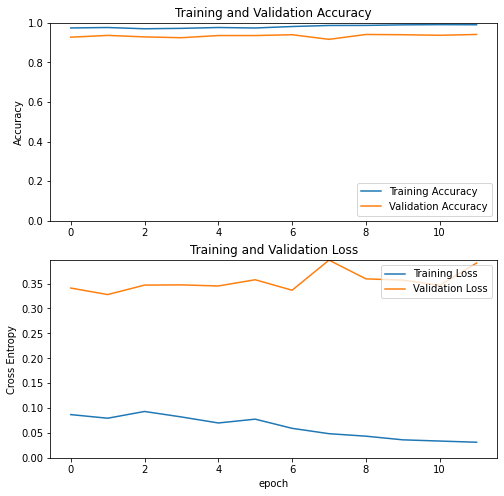

In [ ]:
# Resume training
files = sorted(glob.glob(os.path.join(output_dir, "model.1.**h5")))
if files:
    model_file = files[-1]
    initial_epoch = int(model_file[-10:-8])
    print('Resuming using saved model %s.' % model_file)
    model = load_model(model_file)

# Begin training
else:
  initial_epoch=0

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     min_delta=0,
                                                     patience=10,
                                                     verbose=1, 
                                                     mode='auto',
                                                     restore_best_weights=True)

checkpoint_filename = os.path.join(output_dir, 'model.1.{epoch:02d}-{val_loss:.2f}.h5')
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filename,
                                                   monitor='val_loss',
                                                   verbose=1,
                                                   mode='auto',
                                                   save_best_only=True)

log_dir1 = os.path.join(output_dir, 'logs', "phase1")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir1, profile_batch=5)

history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator),
                    initial_epoch=initial_epoch,
                    epochs=EPOCH_FIRST_PHASE,
                    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],
                    validation_data=val_generator, 
                    validation_steps=len(val_generator))
fig_name = os.path.join(output_dir, 'phase1.jpg')
plot_history(history, fig_name)

In [ ]:
%tensorboard --logdir {log_dir1}

# Second Phase Training

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=optimizer_second_phase,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of layers in the base model:  155
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________
Number of trainable variables = 60


Epoch 1/50
66/66 [==============================] - ETA: 0s - loss: 0.6054 - accuracy: 0.7921
Epoch 00001: val_loss improved from inf to 0.47466, saving model to training/cnp5_splitted/not_augmented_adam_lr0.001_b32_e_100_50/model.2.01-0.47.h5
66/66 [==============================] - 49s 739ms/step - loss: 0.6054 - accuracy: 0.7921 - val_loss: 0.4747 - val_accuracy: 0.8502
Epoch 2/50
66/66 [==============================] - ETA: 0s - loss: 0.3943 - accuracy: 0.8499
Epoch 00002: val_loss did not improve from 0.47466
66/66 [==============================] - 47s 706ms/step - loss: 0.3943 - accuracy: 0.8499 - val_loss: 0.4823 - val_accuracy: 0.8458
Epoch 3/50
66/66 [==============================] - ETA: 0s - loss: 0.3116 - accuracy: 0.8916
Epoch 00003: val_loss improved from 0.47466 to 0.47455, saving model to training/cnp5_splitted/not_augmented_adam_lr0.001_b32_e_100_50/model.2.03-0.47.h5
66/66 [==============================] - 47s 713ms/step - loss: 0.3116 - accuracy: 0.8916 - val_los

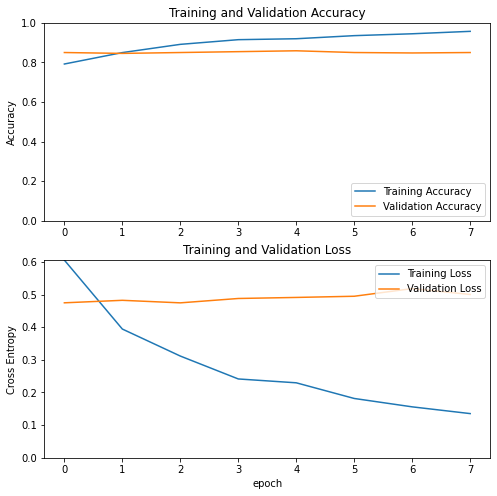

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     min_delta=0,
                                                     patience=5,
                                                     verbose=1, 
                                                     mode='auto',
                                                     restore_best_weights=True)

checkpoint_filename = os.path.join(output_dir, 'model.2.{epoch:02d}-{val_loss:.2f}.h5')
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filename,
                                                   monitor='val_loss',
                                                   verbose=1,
                                                   mode='auto',
                                                   save_best_only=True)

log_dir2 = os.path.join(output_dir, 'logs', "phase2")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, profile_batch=5)

history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=EPOCH_SECOND_PHASE,
                         callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))
fig_name = os.path.join(output_dir, 'phase2.jpg')
plot_history(history_fine, fig_name)

In [ ]:
%tensorboard --logdir {log_dir2}

# Save and export .tflite model

In [ ]:
saved_model_dir = os.path.join(output_dir, 'save/fine_tuning')
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open(os.path.join(output_dir, 'model.tflite'), 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: training/cnp5_splitted/not_augmented_adam_lr0.001_b32_e_100_50/save/fine_tuning/assets


INFO:tensorflow:Assets written to: training/cnp5_splitted/not_augmented_adam_lr0.001_b32_e_100_50/save/fine_tuning/assets


# Run test dataset

In [ ]:
filenames = test_generator.filenames
num_samples = len(filenames)
print("Number of test samples: {}\n".format(num_samples))

# Test dataset predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

cr = classification_report(y_true, y_pred, digits=3)
print(cr)

cm = confusion_matrix(y_true, y_pred)
print(cm)

# Normalize confusion matrix
sums = np.sum(cm, axis=1)
normalized_cm = cm / sums

save_report(cr, cm, normalized_cm, label_keys)

plt.clf()
sns.heatmap(
    normalized_cm, 
    annot=True,
    xticklabels=label_keys,
    yticklabels=label_keys)
plt.title('Normalized Confusion matrix')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

NameError: ignored